In this notebook, we will prepare the data for training with TFOD API. Here's the list of things we are gonna do:
- Calculate `xmax` and `ymax` coordinates and append them to the DataFrame. 
- Rename the `image_id` column to `filename` & add full paths. 
- Create a class column and fill it with the values of `wheat_head` accordingly. 
- Create train and validation splits and separate them in DataFrames. 
- Drop the unnecessary columns from the train and validation DataFrames and serialize the new DataFrames in fresh `.csv` files. 
- Generate TFRecords (ideally should be from Terminal) with a stock `generate_tfrecord.py` script. 
- Prepare the label maps. 

In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from imutils import paths
import pandas as pd
import numpy as np 
import cv2
import os

In [2]:
train_df = pd.read_csv("train_df.csv")
train_df.head()

,image_id,width,height,bbox,source,xmin,ymin
0,b6ab77fd7,56.0,36.0,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0
1,b6ab77fd7,130.0,58.0,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0
2,b6ab77fd7,74.0,160.0,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0
3,b6ab77fd7,109.0,107.0,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0
4,b6ab77fd7,124.0,117.0,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0


In [3]:
def showbbox(image_path, xy, width, height):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(plt.imread(image_path))

    # Create a Rectangle patch
    rect = patches.Rectangle(xy, width, height, 
        linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

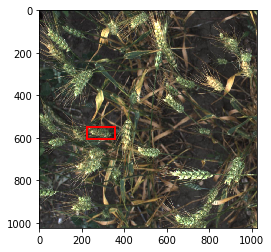

In [4]:
showbbox("train/b6ab77fd7.jpg", (226, 548), 130, 58)

In [5]:
# Calculate xmax and ymax coordinates and append them to the DataFrame
train_df["xmax"] = train_df["xmin"] + train_df["width"]
train_df["ymax"] = train_df["ymin"] + train_df["height"]
train_df.head()

,image_id,width,height,bbox,source,xmin,ymin,xmax,ymax
0,b6ab77fd7,56.0,36.0,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,890.0,258.0
1,b6ab77fd7,130.0,58.0,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,356.0,606.0
2,b6ab77fd7,74.0,160.0,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,451.0,664.0
3,b6ab77fd7,109.0,107.0,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,943.0,202.0
4,b6ab77fd7,124.0,117.0,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,150.0,261.0


In [6]:
# Rename the image_id column to filename & add full paths
train_df.rename(columns={
        "image_id":"filename"
    }, inplace=True)

images_w_bbox = train_df["filename"]
images_w_bbox = ["train/" + image_id + ".jpg" for image_id in images_w_bbox]
train_df["filename"] = images_w_bbox
train_df.head()

,filename,width,height,bbox,source,xmin,ymin,xmax,ymax
0,train/b6ab77fd7.jpg,56.0,36.0,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,890.0,258.0
1,train/b6ab77fd7.jpg,130.0,58.0,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,356.0,606.0
2,train/b6ab77fd7.jpg,74.0,160.0,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,451.0,664.0
3,train/b6ab77fd7.jpg,109.0,107.0,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,943.0,202.0
4,train/b6ab77fd7.jpg,124.0,117.0,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,150.0,261.0


In [7]:
# Drop the unnecessary columns, we will return to this step in a moment
train_df.drop(["source", "bbox"], axis=1, inplace=True)
train_df.head()

,filename,width,height,xmin,ymin,xmax,ymax
0,train/b6ab77fd7.jpg,56.0,36.0,834.0,222.0,890.0,258.0
1,train/b6ab77fd7.jpg,130.0,58.0,226.0,548.0,356.0,606.0
2,train/b6ab77fd7.jpg,74.0,160.0,377.0,504.0,451.0,664.0
3,train/b6ab77fd7.jpg,109.0,107.0,834.0,95.0,943.0,202.0
4,train/b6ab77fd7.jpg,124.0,117.0,26.0,144.0,150.0,261.0


In [8]:
# Add a class column 
train_df["class"] = "wheat_head"
train_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,class
0,train/b6ab77fd7.jpg,56.0,36.0,834.0,222.0,890.0,258.0,wheat_head
1,train/b6ab77fd7.jpg,130.0,58.0,226.0,548.0,356.0,606.0,wheat_head
2,train/b6ab77fd7.jpg,74.0,160.0,377.0,504.0,451.0,664.0,wheat_head
3,train/b6ab77fd7.jpg,109.0,107.0,834.0,95.0,943.0,202.0,wheat_head
4,train/b6ab77fd7.jpg,124.0,117.0,26.0,144.0,150.0,261.0,wheat_head


In [9]:
# Prepare the splits
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_df, test_size=0.15, random_state=666)
print("Training samples:", train.shape[0])
print("Validation samples:", valid.shape[0])

Training samples: 125624
Validation samples: 22169


In [10]:
train = train.reset_index(drop=True)
train.head()

,filename,width,height,xmin,ymin,xmax,ymax,class
0,train/bc226ebfd.jpg,78.0,308.0,946.0,361.0,1024.0,669.0,wheat_head
1,train/87a0373b2.jpg,64.0,57.0,398.0,47.0,462.0,104.0,wheat_head
2,train/29a85cd12.jpg,87.0,71.0,540.0,389.0,627.0,460.0,wheat_head
3,train/9302b9512.jpg,29.0,80.0,970.0,337.0,999.0,417.0,wheat_head
4,train/7f4d07cc0.jpg,115.0,122.0,301.0,315.0,416.0,437.0,wheat_head


In [11]:
valid = valid.reset_index(drop=True)
valid.head()

,filename,width,height,xmin,ymin,xmax,ymax,class
0,train/876e9fc9b.jpg,45.0,80.0,416.0,801.0,461.0,881.0,wheat_head
1,train/de3c12de1.jpg,106.0,70.0,300.0,236.0,406.0,306.0,wheat_head
2,train/f070c6f18.jpg,91.0,69.0,933.0,740.0,1024.0,809.0,wheat_head
3,train/8d4ad2942.jpg,99.0,34.0,445.0,217.0,544.0,251.0,wheat_head
4,train/f1144b38d.jpg,77.0,63.0,686.0,494.0,763.0,557.0,wheat_head


In [12]:
# Serialize the dataframes
train.to_csv("new_train_df.csv")
valid.to_csv("valid_df.csv")

Now, we will be utilizing the `generate_tfrecords.py` script from the [TFOD API GitHub repository](https://github.com/tensorflow/models/tree/master/research/object_detection) to convert the `.csv` records to TFRecords that are compatible with the TFOD API. A [step-by-step guide](https://www.kaggle.com/aakashnain/eda2modelling-tf-object-detection-api) is available here. 

After you create the TFRecords, verify their sizes. Mine looks like so - 
```
$ ls -lh *.record
-rw-r--r-- 1 jupyter jupyter 609M May  6 05:45 train.record
-rw-r--r-- 1 jupyter jupyter 574M May  6 05:46 valid.record
```

In [13]:
# Preparing the label maps
LABEL_ENCODINGS = {
    "wheat_head": 1
}

f = open("label_map.pbtxt", "w")

for (k, v) in LABEL_ENCODINGS.items():
    # construct the class information and write to file
    item = ("item {\n"
            "\tid: " + str(v) + "\n"
            "\tname: '" + k + "'\n"
            "}\n")
    f.write(item)

# close the output classes file
f.close()

In [14]:
!cat label_map.pbtxt

item {
	id: 1
	name: 'wheat_head'
}
